# TP : Implémentation de modèles de diffusion (DDPM)

# Introduction aux modèles de diffusion

Les modèles de diffusion sont une classe de modèles génératifs probabilistes qui fonctionnent en deux étapes principales :

1. **Forward Process (Processus direct)** : Ce processus ajoute progressivement du bruit gaussien à une donnée initiale (par exemple, une image) sur plusieurs étapes, jusqu'à ce que la donnée devienne du bruit pur. Ce processus est défini par une distribution conditionnelle $q(x_t | x_{t-1})$.

2. **Backward Process (Processus inverse)** : Ce processus apprend à inverser le processus direct en débruitant progressivement une donnée bruitée pour générer une donnée réaliste. Cela est réalisé en entraînant un modèle, souvent basé sur une architecture U-Net, pour prédire le bruit ajouté à chaque étape.

Ces modèles sont particulièrement efficaces pour générer des données haute qualité, comme des images, et ont montré des performances compétitives dans des tâches de génération.

---

# Plan du Jupyter Notebook

1. **imports** : importation des bibliothèques nécessaires.
2. **Fonctions utilitaires** : Définition des fonctions pour visualiser et sauvegarder les images générées.
3. **Dataloader** : Chargement du dataset MNIST et préparation des données.
4. **Forward Process** : Implémentation du processus de diffusion direct.
5. **Backward Process** : Construction du modèle U-Net pour le processus inverse.
6. **Algorithme de sampling** : Génération d'images à partir de bruit pur en utilisant le modèle entraîné.
7. **Boucle d'entraînement** : Entraînement du modèle pour apprendre à inverser le processus de diffusion.
8. **Visualisation des résultats** : Affichage des images générées pour évaluer la qualité du modèle.

Les imports

In [1]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import optim
import torchvision
from PIL import Image
!pip install torchinfo
from torchinfo import summary
import torch.nn.functional as F
import numpy as np

Fonctions utiles

In [2]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    num_images = images.shape[0]
    num_cols = 8
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    for i in range(num_rows * num_cols):
        ax = axes[i // num_cols, i % num_cols]
        if i < num_images:
            ax.imshow(images[i].permute(1, 2, 0).cpu())
            ax.axis('off')
        else:
            ax.axis('off')  # Hide unused subplots
    plt.tight_layout()
    plt.show()


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

Dataloader : ici vous créez un dataloader pour charger le dataset MNIST

In [3]:

def get_data(image_size, batch_size):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_size),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    dataset = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transforms)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader


torch.Size([12, 1, 16, 16])


<Figure size 3200x3200 with 0 Axes>

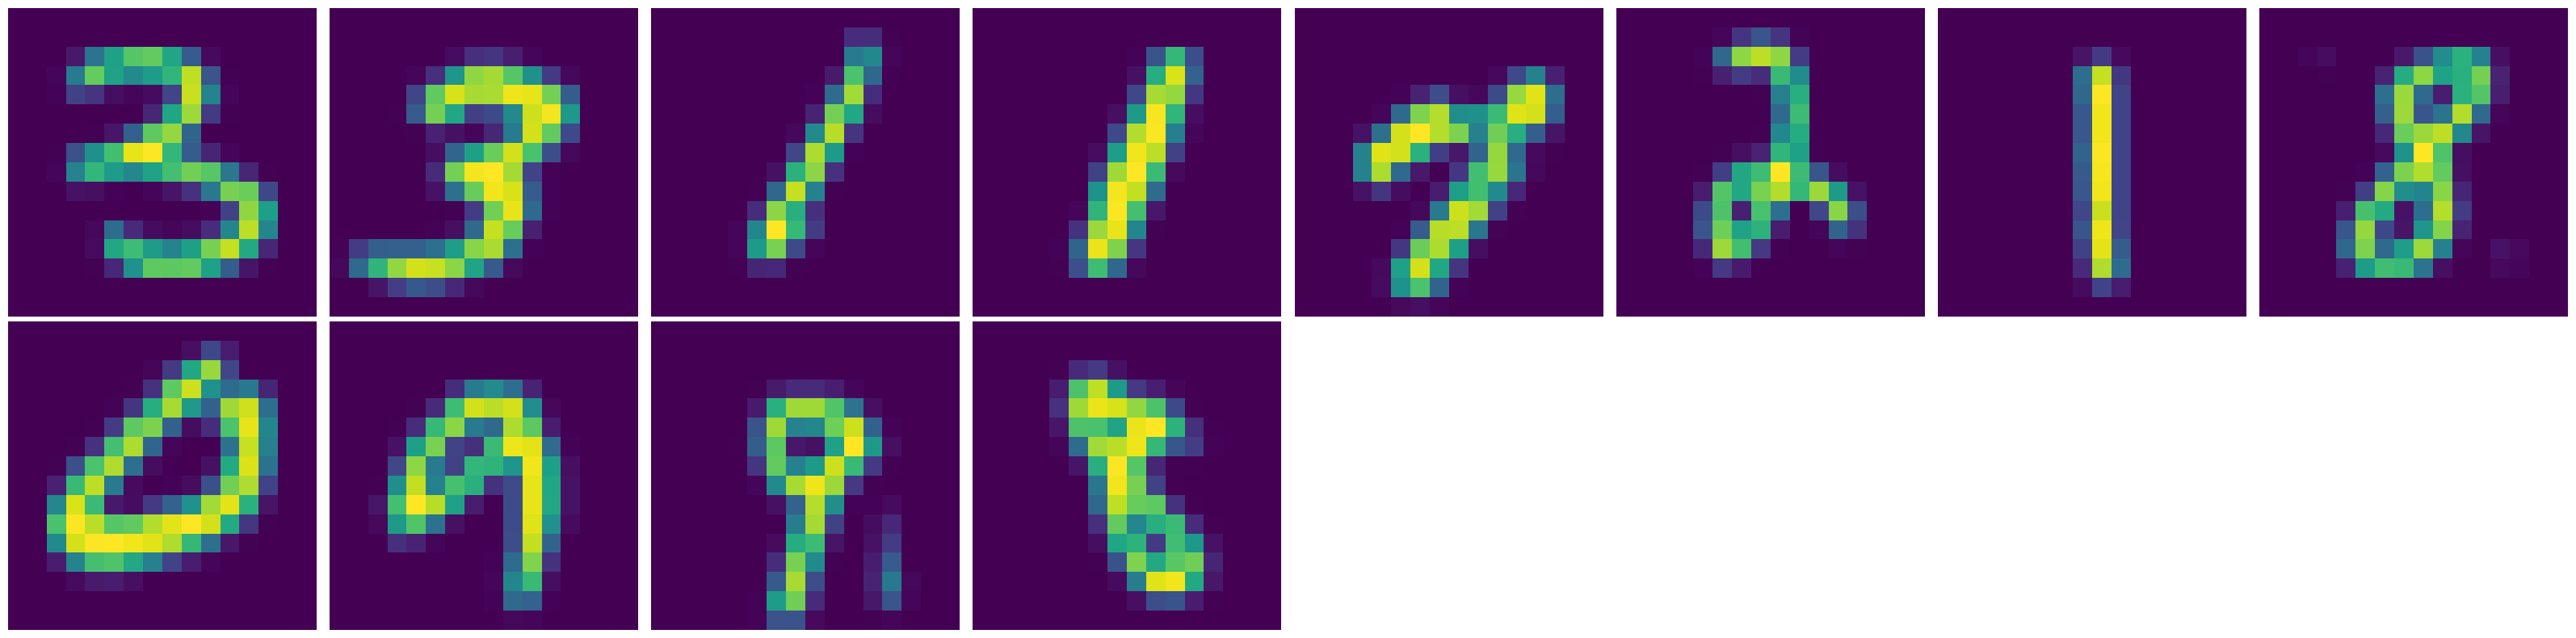

In [4]:
dataloader = get_data(16, 12)
dataiter = iter(dataloader)
a= next(dataiter)
print(a[0].shape)
plot_images(a[0])

Forward process : $q(x_t | x_{t-1}) = N(x_t, \sqrt{1-\beta _t  \cdot x_{t-1}}, \beta _t  \cdot I) $

$ q(x_t | x_{t-1}) = \sqrt{1-\beta _t}  \cdot x_{t-1} + \sqrt{\beta _t}  \cdot \epsilon $ avec $\epsilon$ ~$ N(0,1)$

$ = \sqrt{\alpha _t}  \cdot x_{t-1} + \sqrt{1 - \alpha _t}  \cdot \epsilon $ avec $ \alpha _t = 1 - \beta _t$

$ = \sqrt{\alpha _t}  \cdot (\sqrt{\alpha _{t-1}}  \cdot x_{t-2} + \sqrt{1 - \alpha _{t-1}}  \cdot \epsilon' ) + \sqrt{1 - \alpha _t}  \cdot \epsilon $

$ = \sqrt{\alpha _t} \sqrt{\alpha _{t-1}}  \cdot x_{t-2} + \sqrt{\alpha _t} \sqrt{1 - \alpha _{t-1}}  \cdot \epsilon' + \sqrt{1 - \alpha _t}  \cdot \epsilon $

avec $\epsilon'$ ~ $N(0, \alpha _{t}(1 - \alpha _{t-1}))$ et $\epsilon'$ ~ $N(0, 1- \alpha _{t})$

donc $q(x_t | x_{t-1}) =  \sqrt{\alpha _t \alpha _{t-1}}  \cdot x_{t-2} + \sqrt{1 - \alpha _t \alpha _{t-1}}  \cdot \epsilon $

Et finalement :

$x_t = \sqrt{\hat{\alpha}_t } \cdot x_0 + \sqrt{\hat{\alpha}_t } \cdot \epsilon $ avec
$\hat{\alpha}_t = \prod_{s=1}^t \alpha_s$

In [15]:

class ForwardProcess:
    def __init__(self, noise_steps=100, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        # ici, vous stockez vos variables, et vous créez alpha, bêta, et alpha_hat
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.cosine_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def linear_noise_schedule(self):
        # retourne un tableau de noise_steps valeurs allant de beta_start à beta_end, la  noise_schedule ("plannification du bruit") (le beta quoi)
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def cosine_noise_schedule(self):
        # retourne un tableau de noise_steps valeurs suivant une cosine noise schedule
        steps = torch.linspace(0, self.noise_steps, self.noise_steps + 1, device=self.device)
        alphas_cumprod = torch.cos((steps / self.noise_steps + 0.008) / 1.008 * torch.pi / 2) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clamp(betas, min=0, max=0.999)

    def sample_timesteps(self, n):
        # retourne n timesteps (n valeurs de t) aléatoires (t est entre 1 et self.noise_steps)
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def noise_images(self, x, t):
        # retourne x_t, qui est l'image bruitée au temps t (à la t ième itération de bruit)
        # ici, on utilise la forme mathématique associée à x_t
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        # équivalent à sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t]).view(-1, 1, 1, 1)

        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ


Backward process : Modèle U-Net

Couches utilisées dans le modèle :

Le mécanisme d'attention est décrit par cette formule :

$ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V $


Où :
- \( Q \) (Query), \( K \) (Key), et \( V \) (Value) sont des matrices dérivées des entrées.
- \( d_k \) est la dimension du vecteur Key, utilisé pour le scaling.

In [6]:

class SelfAttention(nn.Module):
    def __init__(self, channels, num_heads=1):
        super().__init__()

        assert channels % num_heads == 0, "channels doit être divisible par num_heads"
        self.num_heads = num_heads
        self.head_dim = channels // num_heads

        self.norm = nn.GroupNorm(1, channels)

        self.qkv = nn.Conv2d(channels, channels*3, kernel_size=1, bias=False)

        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)


    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x) # (B, C, H, W)

        qkv = self.qkv(h).reshape(B, 3, C, H*W) # (B, 3, C, H*W)

        q, k, v = qkv.chunk(3, dim=1) # (B, C, H*W)

        q = q.view(B, self.num_heads, self.head_dim, H * W) # (B, num_heads, head_dim, H*W)
        k = k.view(B, self.num_heads, self.head_dim, H * W)
        v = v.view(B, self.num_heads, self.head_dim, H * W)


        attention = (q.transpose(-2, -1) @ k) / (self.head_dim ** 0.5) # (B, num_heads, H*W, H*W)
        attention = F.softmax(attention, dim=-1)

        out = attention @ v.transpose(-2, -1) # (B, num_heads, H*W, head_dim)
        out = out.transpose(-2, -1).reshape(B, C, H, W) # ici on merge les heads

        out = self.proj_out(out)
        return x + out # skip connection

In [7]:


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb



In [8]:

class UNet(nn.Module):
    def __init__(self, c_in=1, c_out=1, c = 8, time_dim=256, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, c)
        self.down1 = Down(c, 2*c)
        self.sa1 = SelfAttention(2*c, c)
        self.down2 = Down(2*c, 4*c)
        self.sa2 = SelfAttention(4*c, 2*c)
        self.down3 = Down(4*c, 4*c)
        self.sa3 = SelfAttention(4*c, 4)

        self.bot1 = DoubleConv(4*c, 8*c)
        self.bot2 = DoubleConv(8*c, 8*c)
        self.bot3 = DoubleConv(8*c, 4*c)

        self.up1 = Up(8*c, 2*c)
        self.sa4 = SelfAttention(2*c, c)
        self.up2 = Up(4*c, c)
        self.sa5 = SelfAttention(c, c//2)
        self.up3 = Up(2*c, c//2)
        self.sa6 = SelfAttention(c//2, c//4)
        self.outc = nn.Conv2d(c//2, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y=None):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

summary(UNet())

Layer (type:depth-idx)                        Param #
UNet                                          --
├─DoubleConv: 1-1                             --
│    └─Sequential: 2-1                        --
│    │    └─Conv2d: 3-1                       72
│    │    └─GroupNorm: 3-2                    16
│    │    └─GELU: 3-3                         --
│    │    └─Conv2d: 3-4                       576
│    │    └─GroupNorm: 3-5                    16
├─Down: 1-2                                   --
│    └─Sequential: 2-2                        --
│    │    └─MaxPool2d: 3-6                    --
│    │    └─DoubleConv: 3-7                   1,184
│    │    └─DoubleConv: 3-8                   3,520
│    └─Sequential: 2-3                        --
│    │    └─SiLU: 3-9                         --
│    │    └─Linear: 3-10                      4,112
├─SelfAttention: 1-3                          --
│    └─GroupNorm: 2-4                         32
│    └─Conv2d: 2-5                            768
│   

Sampling algorithm :



![image.png](algosampling.png)

Forme du papier CFG : $ \epsilon_t = \epsilon_t^{\varnothing} + cfg\_ scale \cdot (\epsilon_t^y - \epsilon_t^{\varnothing}) $

$\varnothing  \rightarrow$ inférence sans conditionnement (unconditional).

In [9]:
class Sampler:
    def __init__(self, noise_steps=100, beta_start=1e-4, beta_end=0.02, img_size=256, device="cuda"):
        # ici, vous stockez vos variables
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = torch.linspace(self.beta_start, self.beta_end, self.noise_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def sample(self, model, n, labels=None, cfg_scale=3.0):
        # ici, vous codez l'algorithme de sampling, qui permet de réaliser l'inférence de votre modèle
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size)).to(self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    predicted_noise_uncond = model(x, t, None)
                    predicted_noise = predicted_noise + cfg_scale * (predicted_noise - predicted_noise_uncond)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

Boucle d'entraînement

In [10]:
lr = 3e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
run_name = "MNIST"
epoch_start = 20
model = UNet(num_classes=10, device=device)
model.train()
model = model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
mse = nn.MSELoss()

Training algorithm :


![image-2.png](algotraining.png)




In [16]:

def train(run_name, epochs, batch_size, image_size, epoch_start):

    dataloader = get_data(image_size, batch_size)

    diffusion = ForwardProcess(img_size=image_size, device=device)
    sampler = Sampler(img_size=image_size, device=device)
    l = len(dataloader)

    for epoch in range(epochs):
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)

            if np.random.random() < 0.1:
                labels = None

            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())

        sampled_images = sampler.sample(model, n=images.shape[0])
        save_images(sampled_images, os.path.join("results", run_name, f"{epoch+epoch_start}.jpg"))
        torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))


In [21]:

run_name = "DDPM_MNIST"
epochs = 10

os.makedirs("models", exist_ok=True)
os.makedirs("results", exist_ok=True)
os.makedirs(os.path.join("models", run_name), exist_ok=True)
os.makedirs(os.path.join("results", run_name), exist_ok=True)

batch_size = 32
image_size = 16
lr = 3e-4
if os.path.exists("./models/DDPM_MNIST/ckpt.pt"):
    state_dict = torch.load("./models/DDPM_MNIST/ckpt.pt", weights_only=True)
    model.load_state_dict(state_dict)
train(run_name, epochs, batch_size, image_size, epoch_start)
epoch_start += epochs

100%|██████████| 1875/1875 [01:20<00:00, 23.42it/s, MSE=0.0613]
99it [00:01, 50.54it/s]
100%|██████████| 1875/1875 [01:19<00:00, 23.68it/s, MSE=0.0441]
99it [00:01, 50.22it/s]
100%|██████████| 1875/1875 [01:17<00:00, 24.06it/s, MSE=0.0501]
99it [00:01, 51.47it/s]
100%|██████████| 1875/1875 [01:20<00:00, 23.15it/s, MSE=0.0522]
99it [00:01, 50.51it/s]
100%|██████████| 1875/1875 [01:17<00:00, 24.14it/s, MSE=0.0596]
99it [00:01, 51.28it/s]
100%|██████████| 1875/1875 [01:19<00:00, 23.53it/s, MSE=0.0561]
99it [00:01, 50.48it/s]
100%|██████████| 1875/1875 [01:18<00:00, 23.79it/s, MSE=0.0552]
99it [00:02, 39.43it/s]
100%|██████████| 1875/1875 [01:19<00:00, 23.65it/s, MSE=0.0777]
99it [00:01, 51.20it/s]
100%|██████████| 1875/1875 [01:17<00:00, 24.22it/s, MSE=0.053]
99it [00:02, 39.01it/s]
100%|██████████| 1875/1875 [01:18<00:00, 23.84it/s, MSE=0.0517]
99it [00:01, 51.71it/s]


99it [00:02, 49.14it/s]


<Figure size 3200x3200 with 0 Axes>

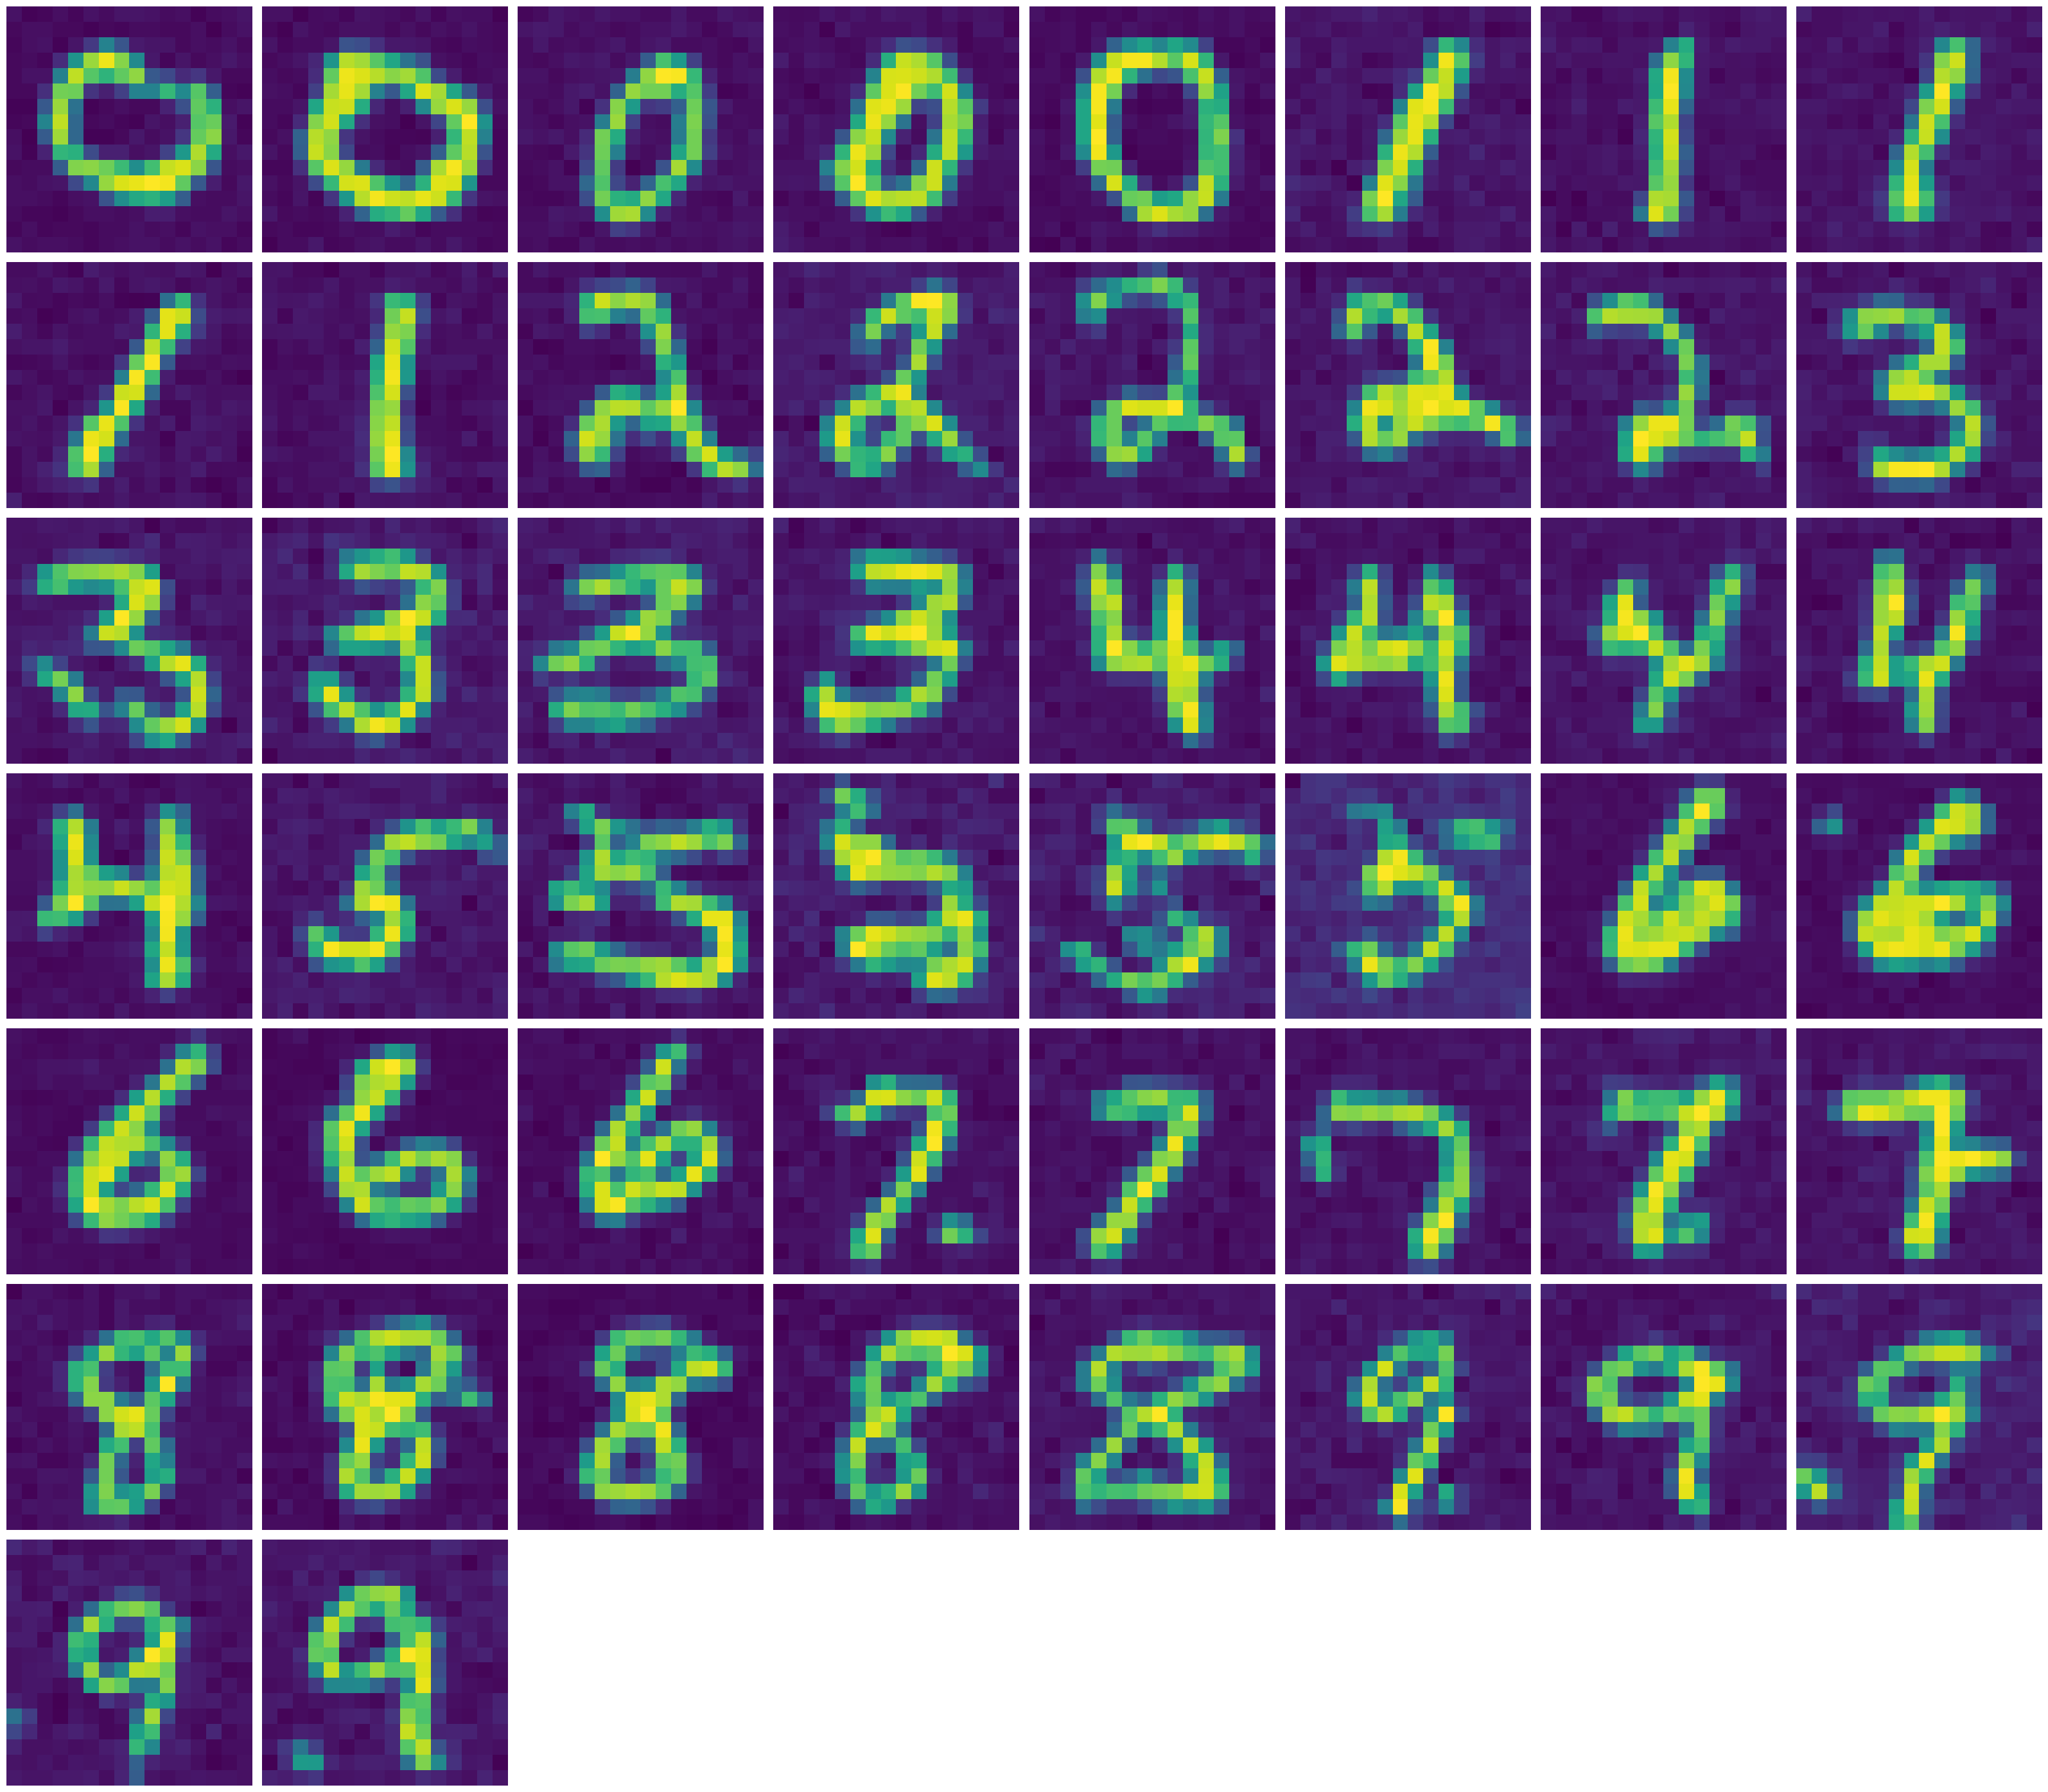

In [23]:
sampler = Sampler(img_size=image_size, device=device)
sampled_images = sampler.sample(model, n=50, labels = torch.arange(10).repeat_interleave(5).to(device))
plot_images(sampled_images)